In [2]:
# Import statements
import os
import numpy as np
import pandas as pd

from utils.ppmi import build_ppmi
from utils.retrofit import sharded_retrofit, join_shards
from utils.formats import load_hdf, save_hdf

In [3]:
### Test heuristics (Refactored for use with PPMI)

import numpy as np
import pandas as pd

def cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two vectors."""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def same_score(word, attribute_set, ppmi_df):
    """Compute the mean cosine similarity between a word and an attribute set."""
    if word not in ppmi_df.index:
        return 0
    word_vec = ppmi_df.loc[word].values
    similarities = [
        cosine_similarity(word_vec, ppmi_df.loc[attr].values)
        for attr in attribute_set if attr in ppmi_df.index
    ]
    return np.mean(similarities) if similarities else 0

def delta_same(target_set, attribute_set_a, attribute_set_b, ppmi_df):
    """Compute the bias score between two attribute sets using SAME."""
    scores_a = [same_score(word, attribute_set_a, ppmi_df) for word in target_set if word in ppmi_df.index]
    scores_b = [same_score(word, attribute_set_b, ppmi_df) for word in target_set if word in ppmi_df.index]
    # print(scores_a)
    # print(scores_b)
    return np.mean(scores_a) - np.mean(scores_b) if scores_a and scores_b else 0

def compute_gender_direction(gender_pairs, gender_pairs2, ppmi_df):
    """Compute the gender direction based on word pairs."""
    differences = []
       # Try primary gender pairs first (c/en/man, c/en/woman)
    for male, female in gender_pairs:
        if male in ppmi_df.index and female in ppmi_df.index:
            diff = ppmi_df.loc[male].values - ppmi_df.loc[female].values
            differences.append(diff)
        else:
            print(f"Skipping pair ({male}, {female}) — one or both not in PPMI (primary).")

    # If none found, try secondary gender pairs (c/en/men, c/en/women)
    if not differences:
        for male, female in gender_pairs2:
            if male in ppmi_df.index and female in ppmi_df.index:
                diff = ppmi_df.loc[male].values - ppmi_df.loc[female].values
                differences.append(diff)
            else:
                print(f"Skipping pair ({male}, {female}) — one or both not in PPMI (fallback).")
    
    if not differences:
        raise ValueError("No valid gender pairs found in PPMI.")

    return np.mean(differences, axis=0)

def direct_bias(word, gender_direction, ppmi_df):
    """Compute the direct bias of a word with respect to gender direction."""
    if word not in ppmi_df.index:
        return 0
    return abs(cosine_similarity(ppmi_df.loc[word].values, gender_direction))

def direct_bias_wordlist(word_list, gender_dir, ppmi_df, label, output_path):
    results = []
    for word in word_list:
        if word in ppmi_df.index:
            bias = direct_bias(word, gender_dir, ppmi_df)
            results.append({"word": word, "bias": bias, "group": label})
        else:
            results.append({"word": word, "bias": None, "group": None})  # Word not in PPMI

    df = pd.DataFrame(results)
    df.to_csv(output_path, index=False)
    return df

def to_conceptnet_uri(word):
    return "/c/en/" + word.strip().lower().replace(" ", "_")



In [4]:
### Variable declarations
ppmi_df = pd.read_hdf('data/conceptnet_api/hdf/test.hdf')
ppmi_df.head()
# print(ppmi_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
/c/en/help_child,5.379521e-16,-0.000013,-0.000002,5.409838e-06,4.022300e-15,-1.130818e-15,5.853341e-17,9.179294e-17,-4.842451e-16,1.788475e-15,...,0.002325,-0.004004,0.000241,-0.025836,-0.041820,0.005383,0.001438,-0.000221,-0.000418,-0.005307
/c/en/adult,-5.947637e-16,-0.000030,0.000002,4.268783e-06,4.570441e-15,-2.390922e-15,9.802262e-16,-1.523202e-15,-9.785777e-16,2.679285e-15,...,0.018061,-0.030400,0.001878,-0.202185,-0.345947,0.045245,0.012511,-0.001947,-0.003833,-0.052088
/c/en/man,3.273319e-16,-0.000016,0.000004,-8.463431e-07,-8.760094e-16,1.120815e-15,-7.305838e-16,-1.708740e-15,5.022793e-16,-7.084706e-16,...,0.155744,-0.142276,0.001892,-0.754510,-0.660803,0.098269,0.024405,-0.007568,0.039280,-0.059049
/c/en/sign_contract,-8.984204e-17,-0.000009,-0.000003,5.824575e-06,4.030767e-15,-1.090103e-15,-1.204847e-16,3.375345e-16,-3.556234e-16,1.765867e-15,...,0.002268,-0.003947,0.000239,-0.025528,-0.041064,0.005288,0.001411,-0.000217,-0.000418,-0.005244
/c/en/dress_herself,-8.856595e-17,-0.000009,-0.000003,5.824575e-06,4.199817e-15,-1.090356e-15,1.005326e-16,1.788506e-16,4.788353e-17,1.832971e-15,...,0.002268,-0.003947,0.000239,-0.025528,-0.041064,0.005288,0.001411,-0.000217,-0.000418,-0.005244


In [5]:
### Reading from csv
female_df = pd.read_csv("data/gendered/gender_f_cleaned.csv", header=None)
male_df = pd.read_csv("data/gendered/gender_m_cleaned.csv", header=None)
neutral_df = pd.read_csv("data/gender_neutral/gender_n_cleaned.csv", header=None)

female_words_target = female_df[0].dropna().apply(to_conceptnet_uri).tolist()
male_words_target = male_df[0].dropna().apply(to_conceptnet_uri).tolist()
neutral_words_target = neutral_df[0].dropna().apply(to_conceptnet_uri).tolist()

In [105]:
### Calculation of heuristics (Benchmark set as this has no edits done)
gender_pairs = [("/c/en/man", "/c/en/woman")]
gender_pairs2 = [("/c/en/men", "/c/en/women")]
attribute_set_a = ["/c/en/he", "/c/en/him", "/c/en/his"]
attribute_set_b = ["/c/en/she", "/c/en/her", "/c/en/hers"]

# --- Run calculations ---
gender_dir = compute_gender_direction(gender_pairs, gender_pairs2, ppmi_df)
# SAME bias calculations
bias_same_neutral = delta_same(neutral_words_target, attribute_set_a, attribute_set_b, ppmi_df)
bias_same_male = delta_same(male_words_target, attribute_set_a, attribute_set_b, ppmi_df)
bias_same_female = delta_same(female_words_target, attribute_set_a, attribute_set_b, ppmi_df)
# Direct bias calculations
bias_direct = direct_bias("/c/en/doctor", gender_dir, ppmi_df)
# Saving direct bias to csv 
output_dir = "data/heuristic/directBias/benchmark"
os.makedirs(output_dir, exist_ok=True)
female_biases = direct_bias_wordlist(female_words_target, gender_dir, ppmi_df, "female", "data/heuristic/directBias/benchmark/female_bias.csv")
male_biases = direct_bias_wordlist(male_words_target, gender_dir, ppmi_df, "male", "data/heuristic/directBias/benchmark/male_bias.csv")
neutral_biases = direct_bias_wordlist(neutral_words_target, gender_dir, ppmi_df, "neutral", "data/heuristic/directBias/benchmark/neutral_bias.csv")

print("Gender direction (preview):", gender_dir[:5])
print("SAME bias score neutral:", bias_same_neutral)
print("SAME bias score male:", bias_same_male)
print("SAME bias score female:", bias_same_female)
print("Direct bias for '/c/en/doctor':", bias_direct)

Gender direction (preview): [-5.22156241e-16 -9.12611510e-05  2.26672453e-05 -5.91807779e-06
 -9.24422121e-16]
SAME bias score neutral: 0.020677905963184078
SAME bias score male: 0.26932468067546717
SAME bias score female: -0.5780757625079354
Direct bias for '/c/en/doctor': 0.6830964319194655


In [106]:
### Hypothesis 1: Does incorporating graph structure into word embeddings reduce bias?
sharded_retrofit(
    dense_hdf_filename="data/conceptnet_api/hdf/test.hdf",
    conceptnet_filename="data/conceptnet_api/csv/edge_extract.csv",
    output_filename="data/conceptnet_api/retrofit/test_retrofitted"
)

join_shards(output_filename="data/conceptnet_api/retrofit/test_retrofitted", nshards=8, sort=False)

retrofitted_ppmi = pd.read_hdf("data/conceptnet_api/retrofit/test_retrofitted")

gender_pairs = [("/c/en/man", "/c/en/woman")]
gender_pairs2 = [("/c/en/men", "/c/en/women")]
attribute_set_a = ["/c/en/he", "/c/en/him", "/c/en/his"]
attribute_set_b = ["/c/en/she", "/c/en/her", "/c/en/hers"]

# --- Run calculations ---
gender_dir = compute_gender_direction(gender_pairs, gender_pairs2, retrofitted_ppmi)
# SAME bias calculations
bias_same_neutral = delta_same(neutral_words_target, attribute_set_a, attribute_set_b, retrofitted_ppmi)
bias_same_male = delta_same(male_words_target, attribute_set_a, attribute_set_b, retrofitted_ppmi)
bias_same_female = delta_same(female_words_target, attribute_set_a, attribute_set_b, retrofitted_ppmi)
# Direct bias calculations
bias_direct = direct_bias("/c/en/doctor", gender_dir, retrofitted_ppmi)
# Saving direct bias to csv 
output_dir = "data/heuristic/directBias/hypothesis1"
os.makedirs(output_dir, exist_ok=True)
female_biases = direct_bias_wordlist(female_words_target, gender_dir, retrofitted_ppmi, "female", "data/heuristic/directBias/hypothesis1/female_bias.csv")
male_biases = direct_bias_wordlist(male_words_target, gender_dir, retrofitted_ppmi, "male", "data/heuristic/directBias/hypothesis1/male_bias.csv")
neutral_biases = direct_bias_wordlist(neutral_words_target, gender_dir, retrofitted_ppmi, "neutral", "data/heuristic/directBias/hypothesis1/neutral_bias.csv")

print("Gender direction (preview):", gender_dir[:5])
print("SAME bias score neutral:", bias_same_neutral)
print("SAME bias score male:", bias_same_male)
print("SAME bias score female:", bias_same_female)
print("Direct bias for '/c/en/doctor':", bias_direct)

Gender direction (preview): [-7.2579083e-17 -1.9953368e-05 -1.9663707e-06 -1.4625811e-05
 -4.0829847e-17]
SAME bias score neutral: nan
SAME bias score male: nan
SAME bias score female: -0.42026755
Direct bias for '/c/en/doctor': 0.5245204


C:\Users\admin\AppData\Local\Temp\ipykernel_297568\2453461954.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


In [107]:
#### Code above was functionality testing, code below demonstrates actual work tried
# Variation 1: Small dataset + Filter (Antonyms)
# First have to edit scraper for filtering.
df = pd.read_csv("data/conceptnet_api/csv/edge_extractVar1.csv")
# print(df.shape)
# print(df['weight'].describe())
# df.head(3)
ppmi_df_var1 = build_ppmi(conceptnet_filename="data/conceptnet_api/csv/edge_extractVar1.csv", ndim=300)
save_hdf(ppmi_df_var1, filename='data/conceptnet_api/hdf/testVar1.hdf')

gender_pairs = [("/c/en/man", "/c/en/woman")]
gender_pairs2 = [("/c/en/men", "/c/en/women")]
attribute_set_a = ["/c/en/he", "/c/en/him", "/c/en/his"]
attribute_set_b = ["/c/en/she", "/c/en/her", "/c/en/hers"]

# --- Run calculations ---
gender_dir = compute_gender_direction(gender_pairs, gender_pairs2, ppmi_df_var1)
# SAME bias calculations
bias_same_neutral = delta_same(neutral_words_target, attribute_set_a, attribute_set_b, ppmi_df_var1)
bias_same_male = delta_same(male_words_target, attribute_set_a, attribute_set_b, ppmi_df_var1)
bias_same_female = delta_same(female_words_target, attribute_set_a, attribute_set_b, ppmi_df_var1)
# Direct bias calculations
bias_direct = direct_bias("/c/en/doctor", gender_dir, ppmi_df_var1)
# Saving direct bias to csv 
output_dir = "data/heuristic/directBias/variation1"
os.makedirs(output_dir, exist_ok=True)
female_biases = direct_bias_wordlist(female_words_target, gender_dir, ppmi_df_var1, "female", "data/heuristic/directBias/variation1/female_bias.csv")
male_biases = direct_bias_wordlist(male_words_target, gender_dir, ppmi_df_var1, "male", "data/heuristic/directBias/variation1/male_bias.csv")
neutral_biases = direct_bias_wordlist(neutral_words_target, gender_dir, ppmi_df_var1, "neutral", "data/heuristic/directBias/variation1/neutral_bias.csv")

print("Gender direction (preview):", gender_dir[:5])
print("SAME bias score neutral:", bias_same_neutral)
print("SAME bias score male:", bias_same_male)
print("SAME bias score female:", bias_same_female)
print("Direct bias for '/c/en/doctor':", bias_direct)

Gender direction (preview): [-1.34992619e-15 -3.14803562e-15 -2.66589376e-05 -2.18844882e-05
  3.24484993e-06]
SAME bias score neutral: 0.020635123338666708
SAME bias score male: 0.2689158195800159
SAME bias score female: -0.5813703747456964
Direct bias for '/c/en/doctor': 0.6820667020592693


In [108]:
# Variation 2: Small dataset + Filter ("/r/Antonym", "/r/NotDesires", "/r/Desires", "/r/ObstructedBy", "/r/MannerOf")
# First have to edit scraper for filtering.
df = pd.read_csv("data/conceptnet_api/csv/edge_extractVar2.csv")
# print(df.shape)
# print(df['weight'].describe())
# df.head(3)
ppmi_df_var2 = build_ppmi(conceptnet_filename="data/conceptnet_api/csv/edge_extractVar2.csv", ndim=300)
save_hdf(ppmi_df_var2, filename='data/conceptnet_api/hdf/testVar2.hdf')

gender_pairs = [("/c/en/man", "/c/en/woman")]
gender_pairs2 = [("/c/en/men", "/c/en/women")]
attribute_set_a = ["/c/en/he", "/c/en/him", "/c/en/his"]
attribute_set_b = ["/c/en/she", "/c/en/her", "/c/en/hers"]

# --- Run calculations ---
gender_dir = compute_gender_direction(gender_pairs, gender_pairs2, ppmi_df_var2)
# SAME bias calculations
bias_same_neutral = delta_same(neutral_words_target, attribute_set_a, attribute_set_b, ppmi_df_var2)
bias_same_male = delta_same(male_words_target, attribute_set_a, attribute_set_b, ppmi_df_var2)
bias_same_female = delta_same(female_words_target, attribute_set_a, attribute_set_b, ppmi_df_var2)
# Direct bias calculations
bias_direct = direct_bias("/c/en/doctor", gender_dir, ppmi_df_var2)
# Saving direct bias to csv 
output_dir = "data/heuristic/directBias/variation2"
os.makedirs(output_dir, exist_ok=True)
female_biases = direct_bias_wordlist(female_words_target, gender_dir, ppmi_df_var2, "female", "data/heuristic/directBias/variation2/female_bias.csv")
male_biases = direct_bias_wordlist(male_words_target, gender_dir, ppmi_df_var2, "male", "data/heuristic/directBias/variation2/male_bias.csv")
neutral_biases = direct_bias_wordlist(neutral_words_target, gender_dir, ppmi_df_var2, "neutral", "data/heuristic/directBias/variation2/neutral_bias.csv")

print("Gender direction (preview):", gender_dir[:5])
print("SAME bias score neutral:", bias_same_neutral)
print("SAME bias score male:", bias_same_male)
print("SAME bias score female:", bias_same_female)
print("Direct bias for '/c/en/doctor':", bias_direct)

Gender direction (preview): [ 3.66054305e-15 -1.09158502e-15  6.77944930e-16 -1.81073787e-15
  1.39121626e-16]
SAME bias score neutral: 0.019407439451583946
SAME bias score male: 0.2681759497124818
SAME bias score female: -0.5816567944429101
Direct bias for '/c/en/doctor': 0.6483519823562606


In [109]:
def check_vocab_coverage(word_list, ppmi_df):
    present = [w for w in word_list if w in ppmi_df.index]
    missing = [w for w in word_list if w not in ppmi_df.index]
    print(f"✔ Found {len(present)} words, ❌ Missing {len(missing)} words")
    return present, missing

print("Neutral coverage:")
_, _ = check_vocab_coverage(neutral_words_target, ppmi_df_var2)

print("Male coverage:")
_, _ = check_vocab_coverage(male_words_target, ppmi_df_var2)

print("Female coverage:")
_, _ = check_vocab_coverage(female_words_target, ppmi_df_var2)

print(ppmi_df_var2.index)

## From here, realised that we are not getting alot of coverage.

Neutral coverage:
✔ Found 115 words, ❌ Missing 5238 words
Male coverage:
✔ Found 29 words, ❌ Missing 494 words
Female coverage:
✔ Found 15 words, ❌ Missing 352 words
Index(['/c/en/help_child', '/c/en/adult', '/c/en/man', '/c/en/sign_contract',
       '/c/en/dress_herself', '/c/en/sheep', '/c/en/adult/n/wn/person',
       '/c/en/fascist/n/wn/person', '/c/en/man/n/wn/person',
       '/c/en/stay_at_home/n/wn/person',
       ...
       '/c/en/quarryman/n/wn/person', '/c/en/slave/n/wn/person',
       '/c/en/tier/n/wn/person', '/c/en/political_officer/n',
       '/c/en/employable/n/wn/person', '/c/en/throwster/n/wn/person',
       '/c/en/freelance/n/wn/person', '/c/en/skidder/n/wn/person',
       '/c/en/solderer/n/wn/person', '/c/en/bleacher/n/wn/person'],
      dtype='object', length=3958)


In [110]:
# Variation 3: Small dataset + Filter (Unidirectional edges)
# First have to edit scraper for filtering.
df = pd.read_csv("data/conceptnet_api/csv/edge_extractVar3.csv")
# print(df.shape)
# print(df['weight'].describe())
# df.head(3)
# Edit the Var numbers below. E.g. edge_extractVar<NUMBER> and testVar<NUMBER>
ppmi_df_var3 = build_ppmi(conceptnet_filename="data/conceptnet_api/csv/edge_extractVar3.csv", ndim=300)
save_hdf(ppmi_df_var3, filename='data/conceptnet_api/hdf/testVar3.hdf')

gender_pairs = [("/c/en/man", "/c/en/woman")]
gender_pairs2 = [("/c/en/men", "/c/en/women")]
attribute_set_a = ["/c/en/he", "/c/en/him", "/c/en/his"]
attribute_set_b = ["/c/en/she", "/c/en/her", "/c/en/hers"]

# --- Run calculations ---
gender_dir = compute_gender_direction(gender_pairs, gender_pairs2, ppmi_df_var3)
# SAME bias calculations
bias_same_neutral = delta_same(neutral_words_target, attribute_set_a, attribute_set_b, ppmi_df_var3)
bias_same_male = delta_same(male_words_target, attribute_set_a, attribute_set_b, ppmi_df_var3)
bias_same_female = delta_same(female_words_target, attribute_set_a, attribute_set_b, ppmi_df_var3)
# Direct bias calculations
bias_direct = direct_bias("/c/en/doctor", gender_dir, ppmi_df_var3)
# Saving direct bias to csv 
output_dir = "data/heuristic/directBias/variation3"
os.makedirs(output_dir, exist_ok=True)
female_biases = direct_bias_wordlist(female_words_target, gender_dir, ppmi_df_var3, "female", "data/heuristic/directBias/variation3/female_bias.csv")
male_biases = direct_bias_wordlist(male_words_target, gender_dir, ppmi_df_var3, "male", "data/heuristic/directBias/variation3/male_bias.csv")
neutral_biases = direct_bias_wordlist(neutral_words_target, gender_dir, ppmi_df_var3, "neutral", "data/heuristic/directBias/variation3/neutral_bias.csv")

print("Gender direction (preview):", gender_dir[:5])
print("SAME bias score neutral:", bias_same_neutral)
print("SAME bias score male:", bias_same_male)
print("SAME bias score female:", bias_same_female)
print("Direct bias for '/c/en/doctor':", bias_direct)

Gender direction (preview): [-1.07127059e-17  1.20317390e-15 -7.71549783e-16 -3.44391595e-16
  2.96811941e-05]
SAME bias score neutral: 0.02209098032974399
SAME bias score male: 0.22033426697084874
SAME bias score female: -0.5469579272834754
Direct bias for '/c/en/doctor': 0.6910107221797888


In [6]:
### Hypothesis 2:
## Scraping from ConceptNet
import filter_ablation
import importlib
import conceptnet_api_scraper
importlib.reload(conceptnet_api_scraper)
importlib.reload(filter_ablation)
from conceptnet_api_scraper import parse_response

JSON_PATH = os.path.join(os.getcwd(), "data", "conceptnet_api", "json")
CSV_PATH = os.path.join(os.getcwd(), "data", "conceptnet_api", "csv")

for filter_name, filter in filter_ablation.get_all_filter_chains().items(): 
  keywords_df = parse_response(input_folder=JSON_PATH, output_folder=CSV_PATH, edge_filter=filter)
  keywords_df.to_csv(f'{CSV_PATH}/edge_extract_{filter_name}.csv', index=False)

100%|██████████| 67/67 [00:00<00:00, 909.03it/s]


In [7]:
def load_glove_embeddings(glove_path):
    glove_dict = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            glove_dict[word] = vec
    return glove_dict

glove_dict = load_glove_embeddings("data/conceptnet_api/glove.6B/glove.6B.300d.txt")

In [8]:
### Util functions
def from_conceptnet_uri(uri):
    return uri.replace("/c/en/", "").replace("_", " ")

# Function to get cosine similarity between GloVe and ConceptNet embeddings
def compare_glove_conceptnet(uri_list, group_name, glove_dict, conceptnet_dict):
    similarities = []
    for uri in uri_list:
        word = from_conceptnet_uri(uri)
        if word in glove_dict and uri in conceptnet_dict:
            sim = cosine_similarity(glove_dict[word], conceptnet_dict[uri])
            similarities.append((word, sim))
    return similarities

In [9]:
### Hypothesis 2: 
## Generating the heuristic scores
import os
import pandas as pd
from utils.retrofit import sharded_retrofit, join_shards

# === Paths ===
CSV_PATH = "data/conceptnet_api/csv"
HDF_PATH = "data/conceptnet_api/hdf"
RETROFIT_PATH = "data/conceptnet_api/retrofit"
BIAS_OUTPUT_ROOT = "data/heuristic/directBias"
EVAL_OUTPUT = "data/conceptnet_api/eval"
os.makedirs(HDF_PATH, exist_ok=True)
os.makedirs(RETROFIT_PATH, exist_ok=True)
os.makedirs(BIAS_OUTPUT_ROOT, exist_ok=True)
os.makedirs(EVAL_OUTPUT, exist_ok=True)

# === Bias Config ===
gender_pairs = [("/c/en/man", "/c/en/woman")]
gender_pairs2 = [("/c/en/men", "/c/en/women")]
attribute_set_a = ["/c/en/he", "/c/en/him", "/c/en/his"]
attribute_set_b = ["/c/en/she", "/c/en/her", "/c/en/hers"]

# === Target Word Lists ===

csv_files = [f for f in os.listdir(CSV_PATH) if f.startswith("edge_extract_") and f.endswith(".csv")]

for file in csv_files:
    filter_name = file.replace("edge_extract_", "").replace(".csv", "")
    print(f"\n🚀 Processing filter variation: {filter_name}")

    # Step 1: Build PPMI
    input_csv = os.path.join(CSV_PATH, file)
    dense_hdf_path = os.path.join(HDF_PATH, f"test_{filter_name}.hdf")
    ppmi_df = build_ppmi(conceptnet_filename=input_csv, ndim=300)
    save_hdf(ppmi_df, filename=dense_hdf_path)

    # Step 2: Retrofitting
    retrofit_prefix = os.path.join(RETROFIT_PATH, f"test_retrofitted_{filter_name}")
    sharded_retrofit(
        dense_hdf_filename=dense_hdf_path,
        conceptnet_filename=input_csv,
        output_filename=retrofit_prefix
    )

    # Step 3: Join shards
    join_shards(output_filename=retrofit_prefix, nshards=10, sort=False)

    # Step 4: Load retrofitted PPMI
    retrofitted_hdf = retrofit_prefix  # joined result has no extension
    if not os.path.exists(retrofitted_hdf):
        print(f"⚠️ Skipping {filter_name}, retrofitted file not found")
        continue

    ppmi_df = pd.read_hdf(retrofitted_hdf)

    conceptnet_dict = {k: v.values for k, v in ppmi_df.iterrows()}

    female_similarities = compare_glove_conceptnet(female_words_target, "female", glove_dict, conceptnet_dict)
    male_similarities = compare_glove_conceptnet(male_words_target, "male", glove_dict, conceptnet_dict)
    neutral_similarities = compare_glove_conceptnet(neutral_words_target, "neutral", glove_dict, conceptnet_dict)

    # Create a DataFrame from each similarity list
    female_df_out = pd.DataFrame(female_similarities, columns=["word", "cosine_similarity"])
    male_df_out = pd.DataFrame(male_similarities, columns=["word", "cosine_similarity"])
    neutral_df_out = pd.DataFrame(neutral_similarities, columns=["word", "cosine_similarity"])

    # Define output filenames
    similarity_dir = os.path.join(EVAL_OUTPUT, "cosine_similarity", filter_name)
    os.makedirs(similarity_dir, exist_ok=True)

    female_df_out.to_csv(os.path.join(similarity_dir, "female_glove_vs_conceptnet.csv"), index=False)
    male_df_out.to_csv(os.path.join(similarity_dir, "male_glove_vs_conceptnet.csv"), index=False)
    neutral_df_out.to_csv(os.path.join(similarity_dir, "neutral_glove_vs_conceptnet.csv"), index=False)

    # Step 5: Compute bias heuristics
    gender_dir = compute_gender_direction(gender_pairs, gender_pairs2, ppmi_df)

    bias_same_neutral = delta_same(neutral_words_target, attribute_set_a, attribute_set_b, ppmi_df)
    bias_same_male = delta_same(male_words_target, attribute_set_a, attribute_set_b, ppmi_df)
    bias_same_female = delta_same(female_words_target, attribute_set_a, attribute_set_b, ppmi_df)
    bias_direct_doctor = direct_bias("/c/en/doctor", gender_dir, ppmi_df)

    # Step 6: Save direct bias scores
    output_dir = os.path.join(BIAS_OUTPUT_ROOT, f"variation_{filter_name}")
    os.makedirs(output_dir, exist_ok=True)

    direct_bias_wordlist(female_words_target, gender_dir, ppmi_df, "female", os.path.join(output_dir, "female_bias.csv"))
    direct_bias_wordlist(male_words_target, gender_dir, ppmi_df, "male", os.path.join(output_dir, "male_bias.csv"))
    direct_bias_wordlist(neutral_words_target, gender_dir, ppmi_df, "neutral", os.path.join(output_dir, "neutral_bias.csv"))

    # Step 7: Summary print
    print("📊 SAME Bias (Neutral):", bias_same_neutral)
    print("📊 SAME Bias (Male):", bias_same_male)
    print("📊 SAME Bias (Female):", bias_same_female)
    print("📊 Direct Bias ('/c/en/doctor'):", bias_direct_doctor)
    print(f"✅ Completed variation: {filter_name}")

    # Only overwrite the file the first time
    if 'first_write' not in globals():
        first_write = True

    summary_path = os.path.join(EVAL_OUTPUT, "eval_summary.txt")
    mode = "w" if first_write else "a"

    # Step 8: Save results summary to a .txt file
    with open(summary_path, mode) as f:
        f.write(f"===== Bias Results for Filter: {filter_name} =====\n")
        f.write(f"SAME Bias (Neutral): {bias_same_neutral:.4f}\n")
        f.write(f"SAME Bias (Male):    {bias_same_male:.4f}\n")
        f.write(f"SAME Bias (Female):  {bias_same_female:.4f}\n")
        f.write(f"Direct Bias ('/c/en/doctor'): {bias_direct_doctor:.4f}\n")
        f.write("--------------------------------------------------\n\n")

    first_write = False  # Switch to append mode after first time



🚀 Processing filter variation: baseline
📊 SAME Bias (Neutral): 0.033242006
📊 SAME Bias (Male): 0.25216886
📊 SAME Bias (Female): -0.5132581
📊 Direct Bias ('/c/en/doctor'): 0.45221505
✅ Completed variation: baseline

🚀 Processing filter variation: baseline_lenient
📊 SAME Bias (Neutral): 0.026784547
📊 SAME Bias (Male): 0.22245887
📊 SAME Bias (Female): -0.35154822
📊 Direct Bias ('/c/en/doctor'): 0.47130355
✅ Completed variation: baseline_lenient

🚀 Processing filter variation: baseline_strict
📊 SAME Bias (Neutral): 0.027497774
📊 SAME Bias (Male): 0.3677098
📊 SAME Bias (Female): -0.41915584
📊 Direct Bias ('/c/en/doctor'): 0.48330107
✅ Completed variation: baseline_strict

🚀 Processing filter variation: comprehensive
📊 SAME Bias (Neutral): 0.047786854
📊 SAME Bias (Male): 0.19768567
📊 SAME Bias (Female): -0.42035985
📊 Direct Bias ('/c/en/doctor'): 0.5072794
✅ Completed variation: comprehensive

🚀 Processing filter variation: comprehensive_high_quality
📊 SAME Bias (Neutral): 0.048887245
📊 SAM

['===== Bias Results for Filter: baseline =====', 'SAME Bias (Neutral): 0.0332', 'SAME Bias (Male):    0.2522', 'SAME Bias (Female):  -0.5133', "Direct Bias ('/c/en/doctor'): 0.4522", '--------------------------------------------------', '===== Bias Results for Filter: baseline_lenient =====', 'SAME Bias (Neutral): 0.0268', 'SAME Bias (Male):    0.2225', 'SAME Bias (Female):  -0.3515', "Direct Bias ('/c/en/doctor'): 0.4713", '--------------------------------------------------', '===== Bias Results for Filter: baseline_strict =====', 'SAME Bias (Neutral): 0.0275', 'SAME Bias (Male):    0.3677', 'SAME Bias (Female):  -0.4192', "Direct Bias ('/c/en/doctor'): 0.4833", '--------------------------------------------------', '===== Bias Results for Filter: comprehensive =====', 'SAME Bias (Neutral): 0.0478', 'SAME Bias (Male):    0.1977', 'SAME Bias (Female):  -0.4204', "Direct Bias ('/c/en/doctor'): 0.5073", '--------------------------------------------------', '===== Bias Results for Filter:

C:\Users\admin\AppData\Local\Temp\ipykernel_22520\1437860445.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


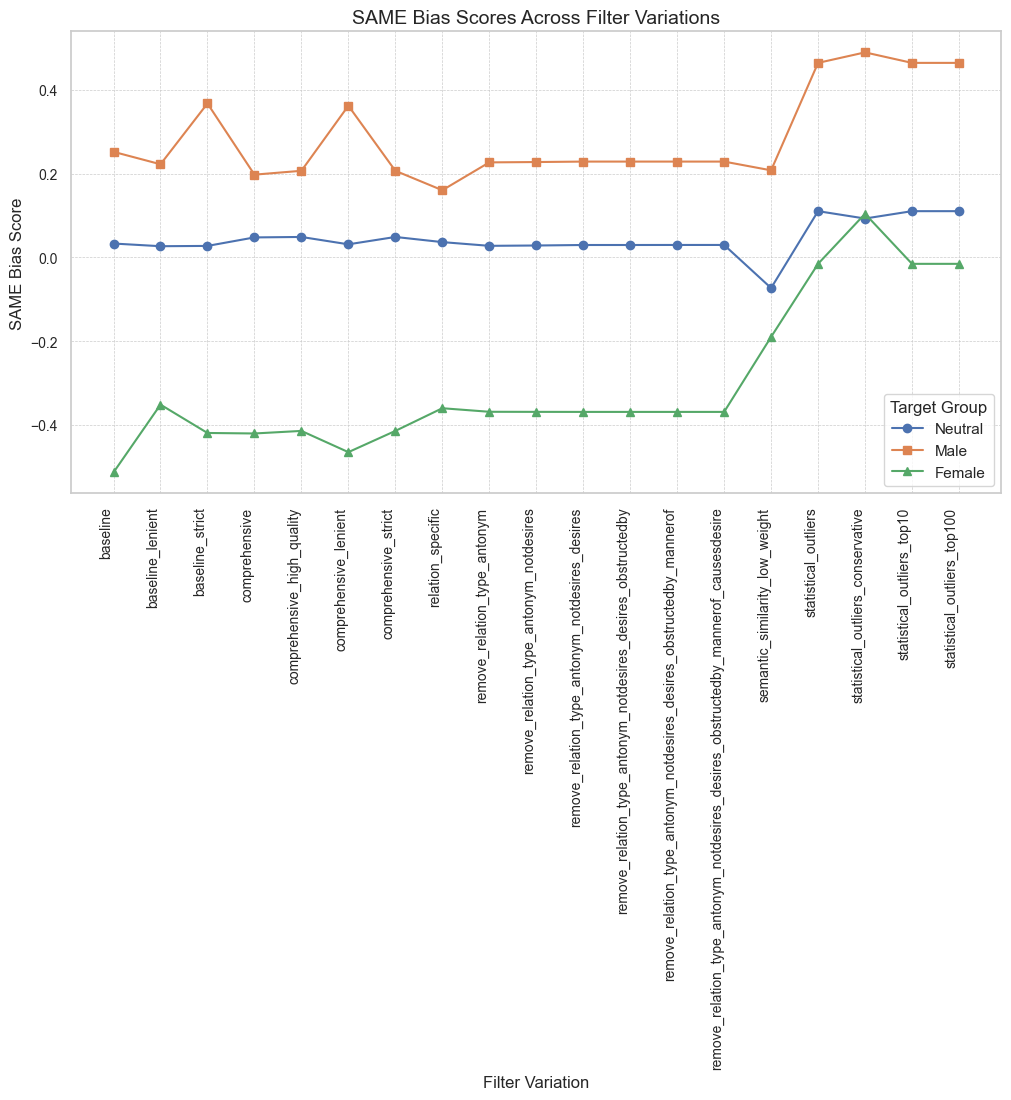

In [ ]:
### Plots for SAME score against filters
import matplotlib.pyplot as plt
import seaborn as sns

# Set style to match your second graph
sns.set(style="whitegrid")

# Re-parse the summary file
summary_path = os.path.join(EVAL_OUTPUT, "eval_summary.txt")

with open(summary_path, "r") as f:
    lines = [line.strip() for line in f.readlines() if line.strip()]

filter_names = []
same_neutral = []
same_male = []
same_female = []

i = 0
while i < len(lines):
    line = lines[i]
    if line.startswith("===== Bias Results for Filter:"):
        try:
            filter_name = line.split(":")[1].strip().strip("= ").strip()
            neutral = float(lines[i+1].split(":")[1].strip())
            male = float(lines[i+2].split(":")[1].strip())
            female = float(lines[i+3].split(":")[1].strip())

            # Use tolerance check to skip all-0 entries
            if abs(neutral) < 1e-5 and abs(male) < 1e-5 and abs(female) < 1e-5:
                i += 5
                continue

            filter_names.append(filter_name)
            same_neutral.append(neutral)
            same_male.append(male)
            same_female.append(female)
        except Exception as e:
            print(f"Skipping malformed block at line {i}: {e}")
        i += 5  # move to next block
    else:
        i += 1


# Plot with cleaner layout
plt.figure(figsize=(12, 6))
plt.plot(filter_names, same_neutral, marker='o', label="Neutral")
plt.plot(filter_names, same_male, marker='s', label="Male")
plt.plot(filter_names, same_female, marker='^', label="Female")

plt.title("SAME Bias Scores Across Filter Variations", fontsize=14)
plt.xlabel("Filter Variation", fontsize=12)
plt.ylabel("SAME Bias Score", fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.legend(title="Target Group")
plt.grid(True, linestyle="--", linewidth=0.5)

# Save the improved plot
plt.savefig(os.path.join(EVAL_OUTPUT, "same_bias_scores_by_filter_cleaned.png"), dpi=300)
plt.show()

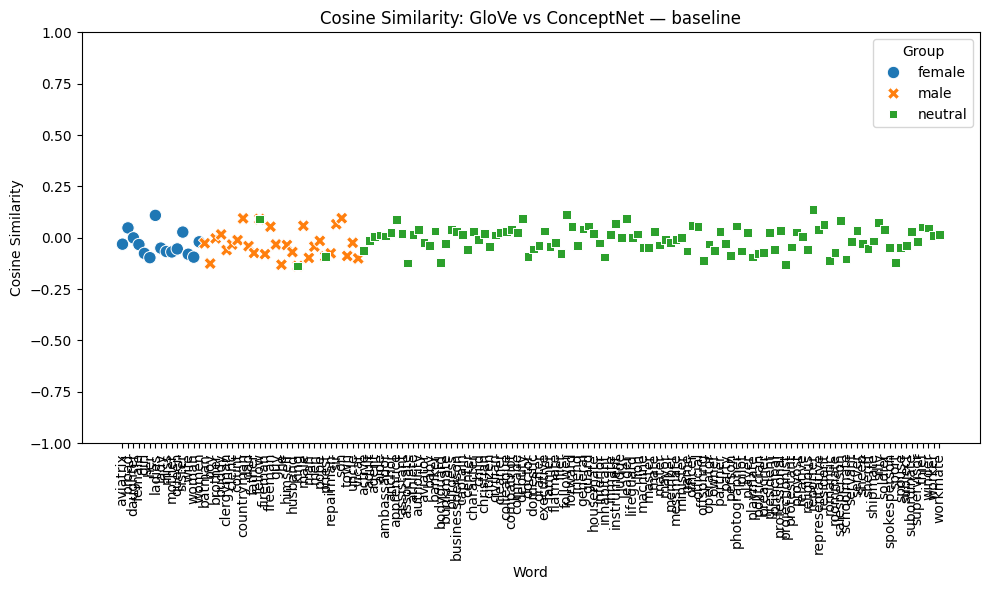

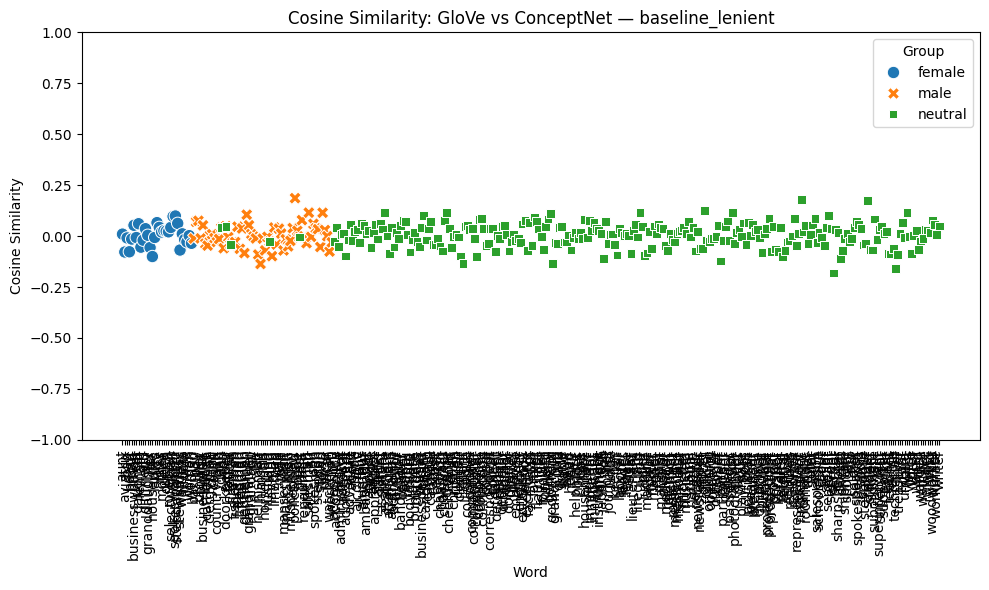

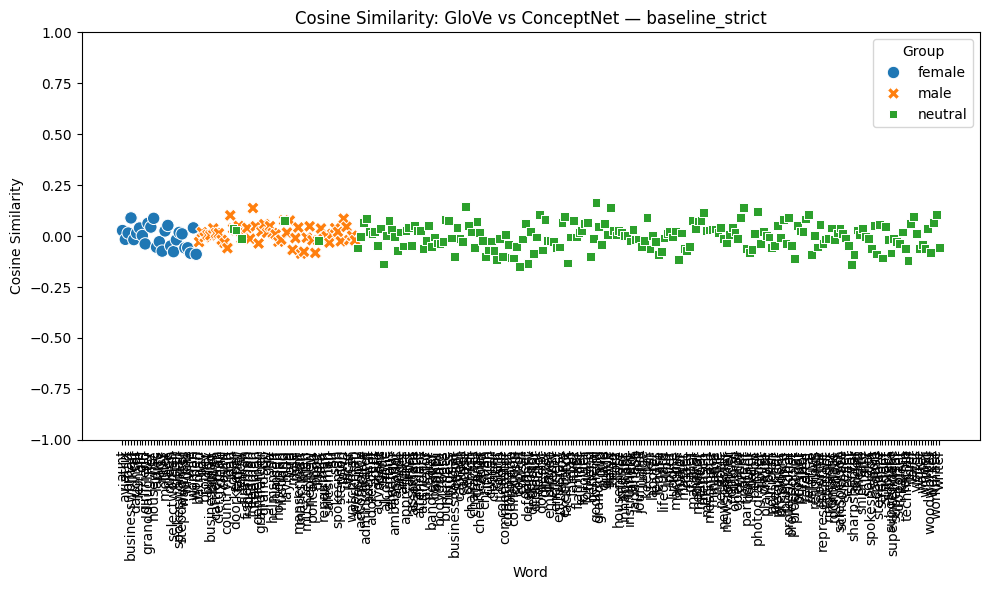

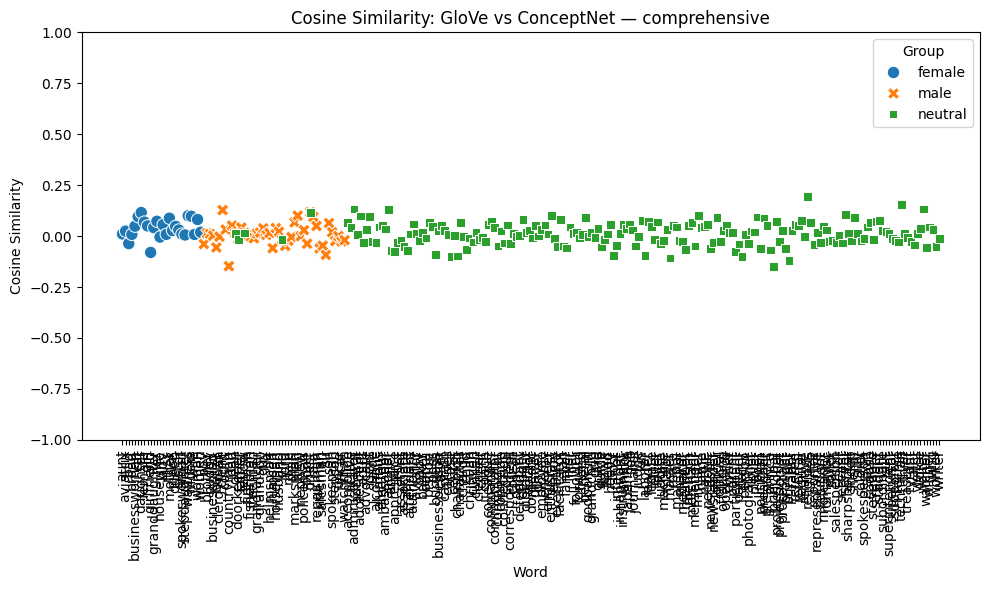

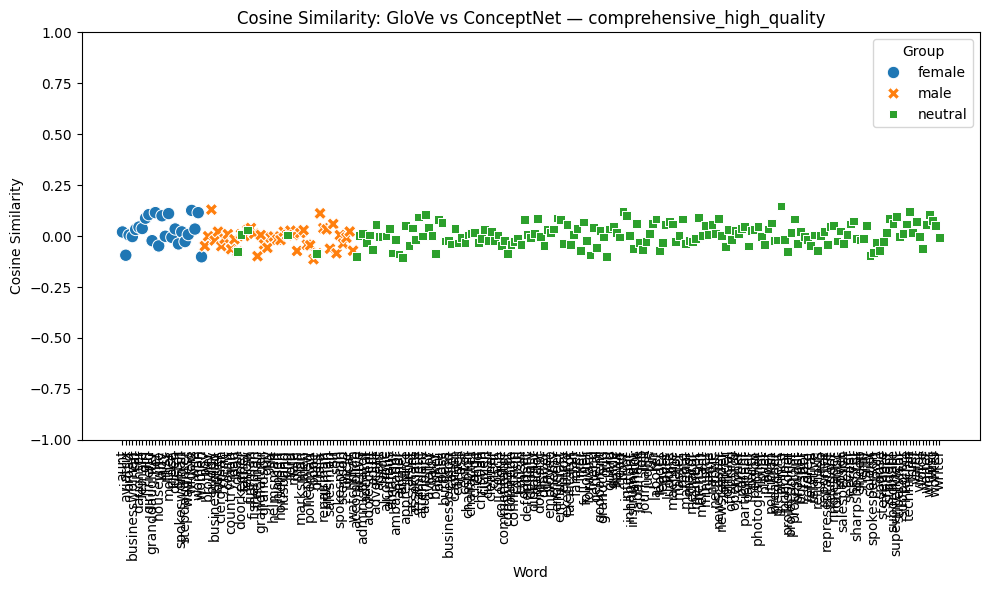

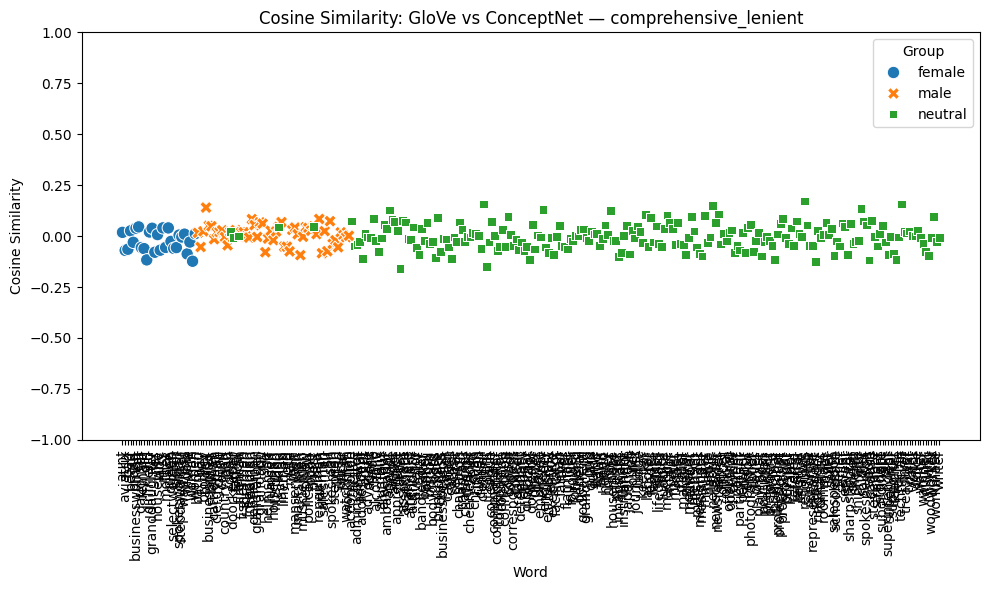

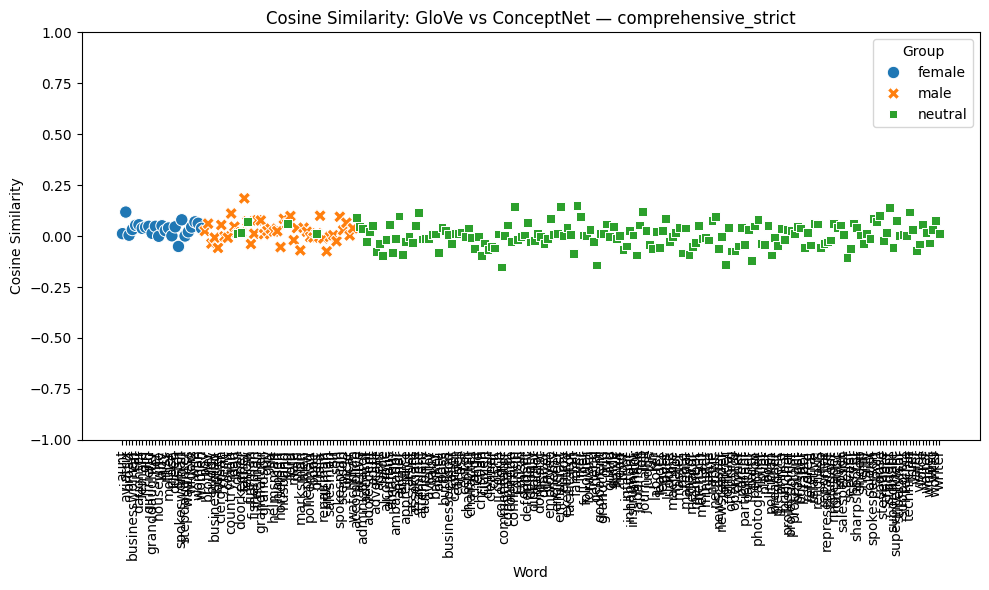

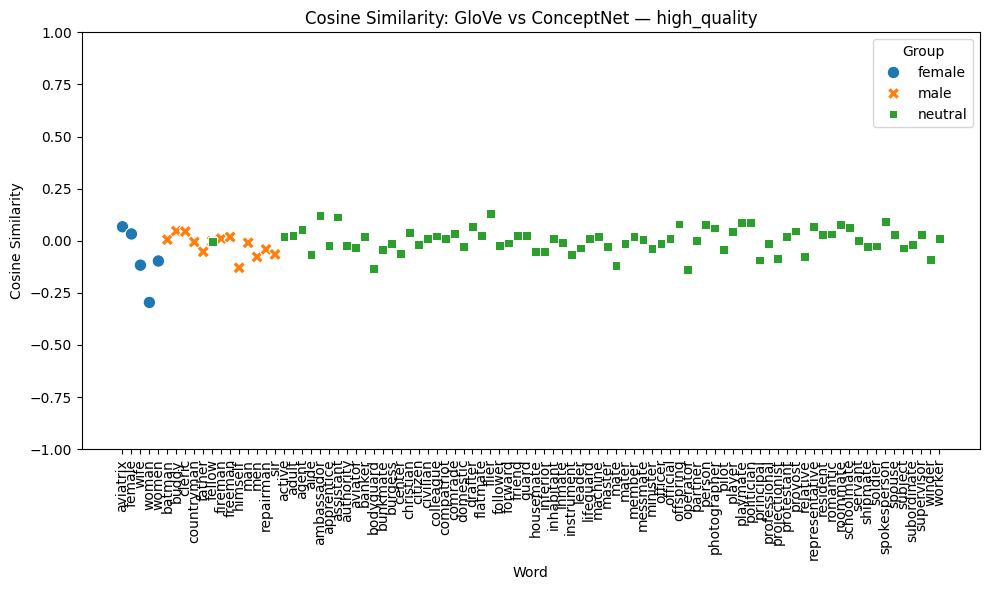

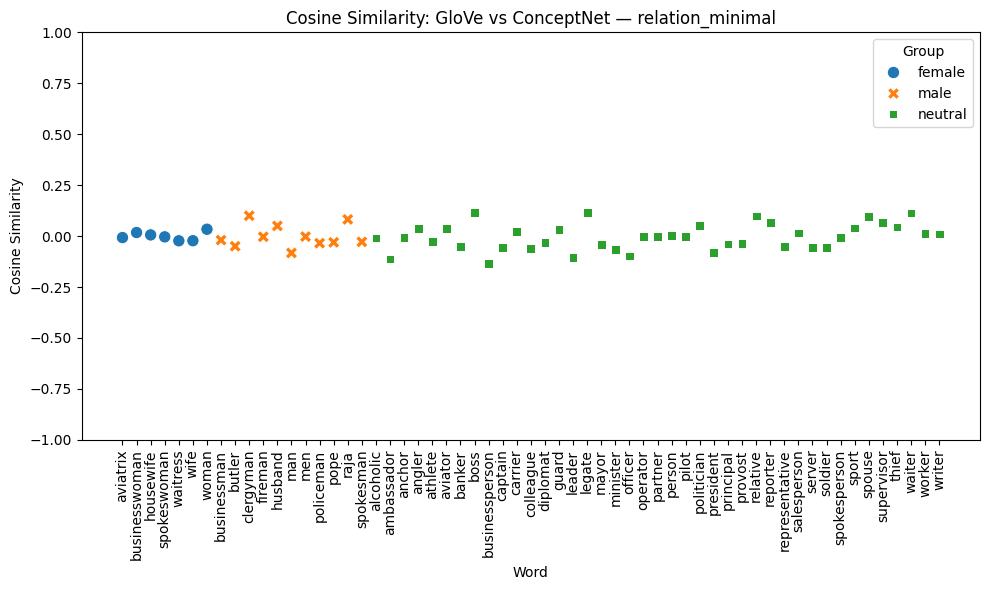

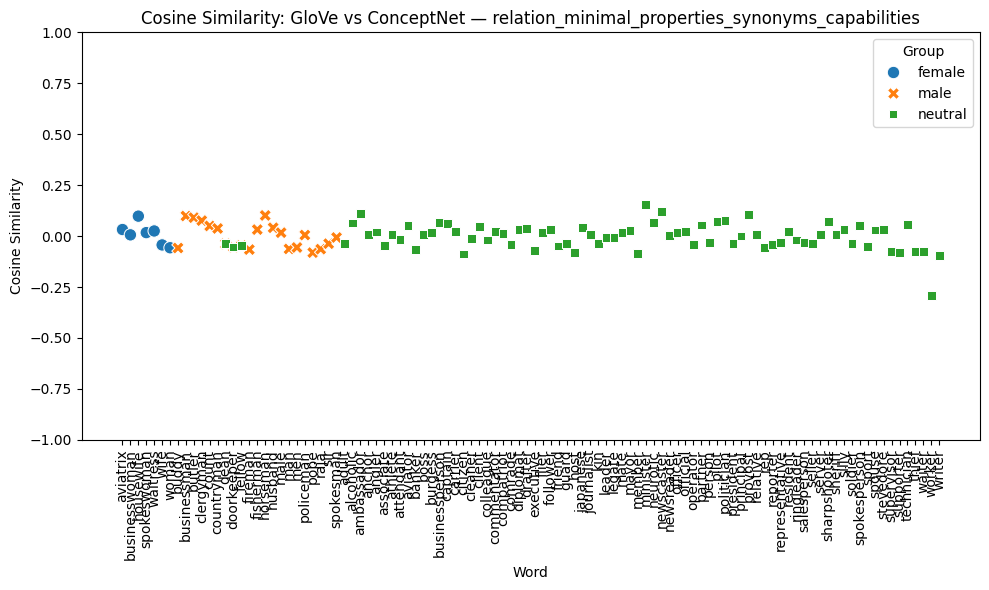

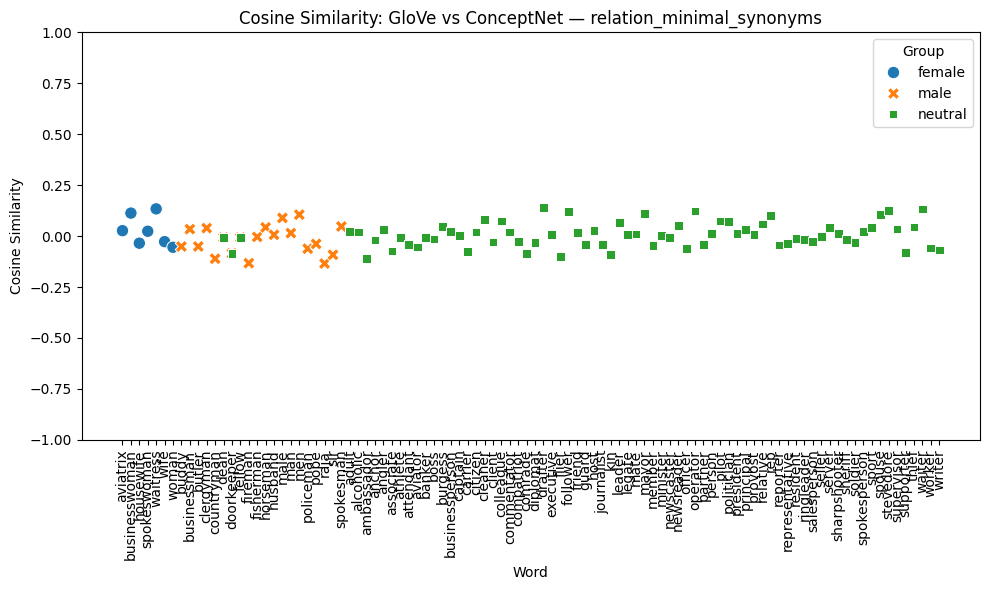

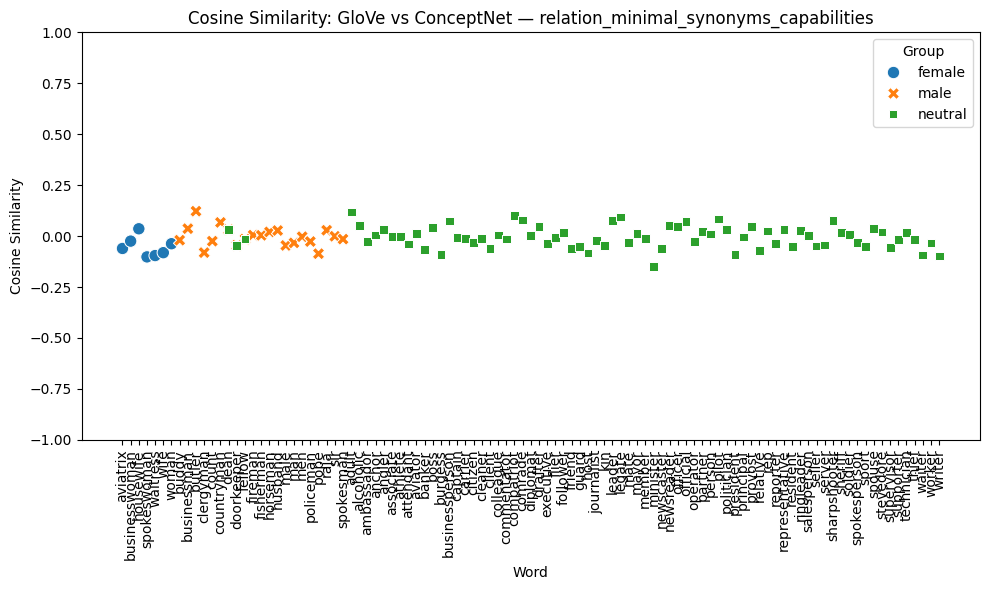

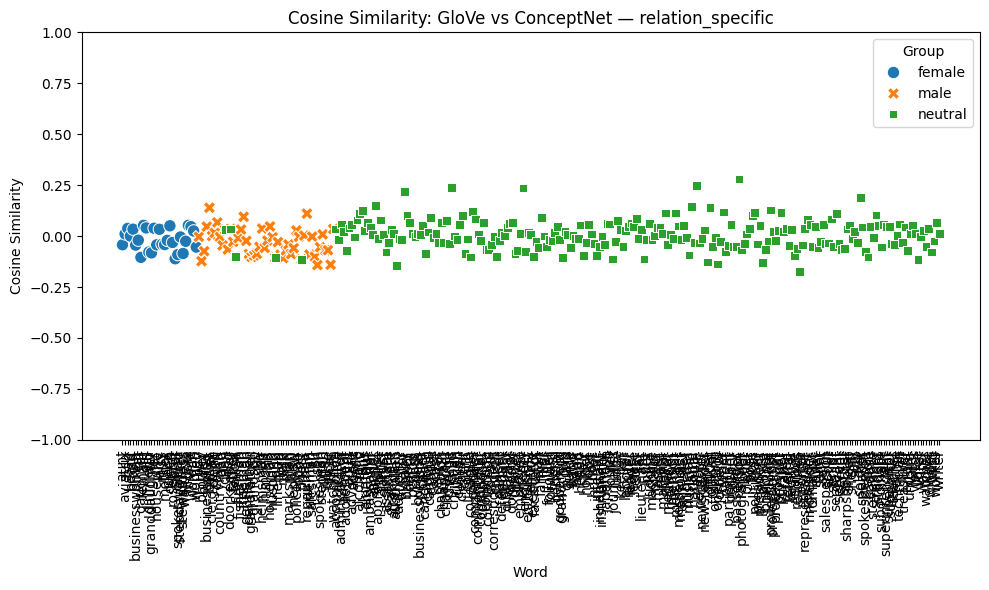

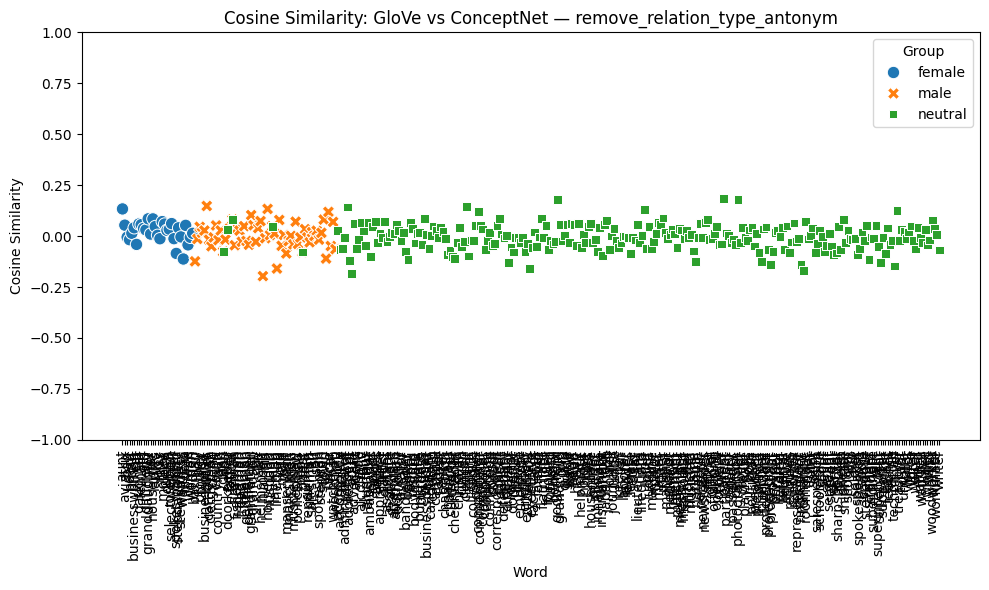

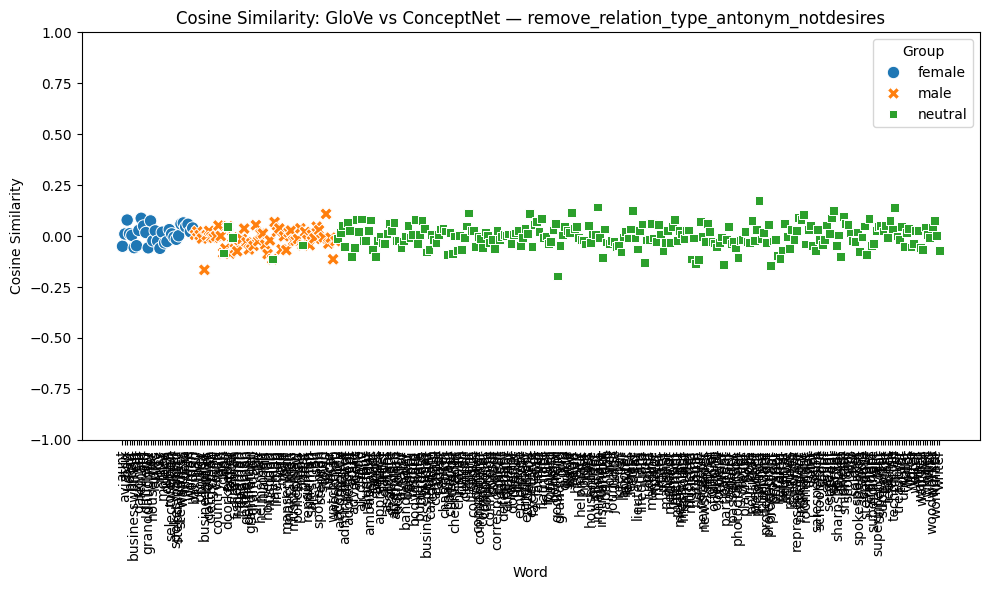

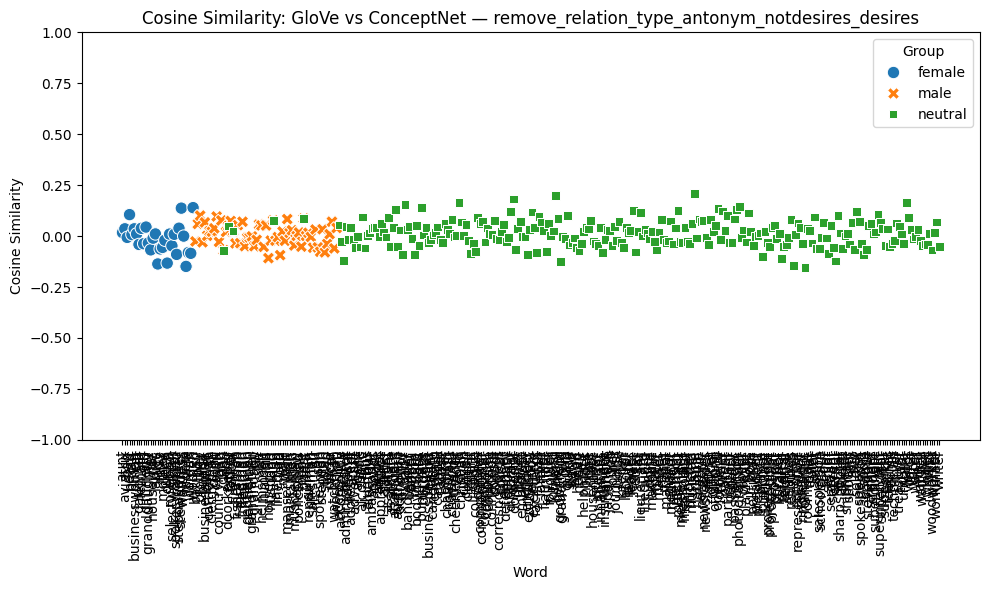

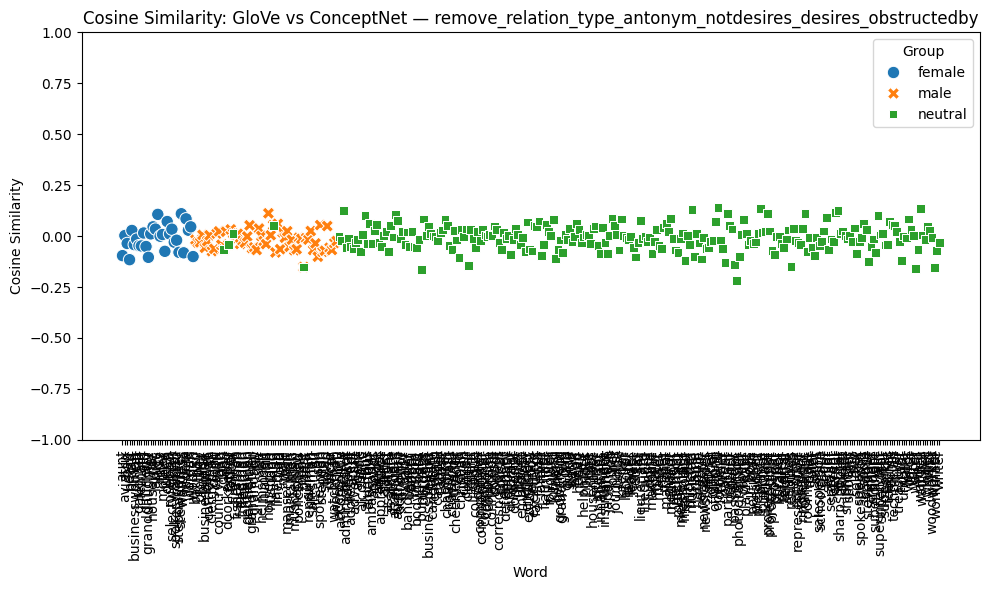

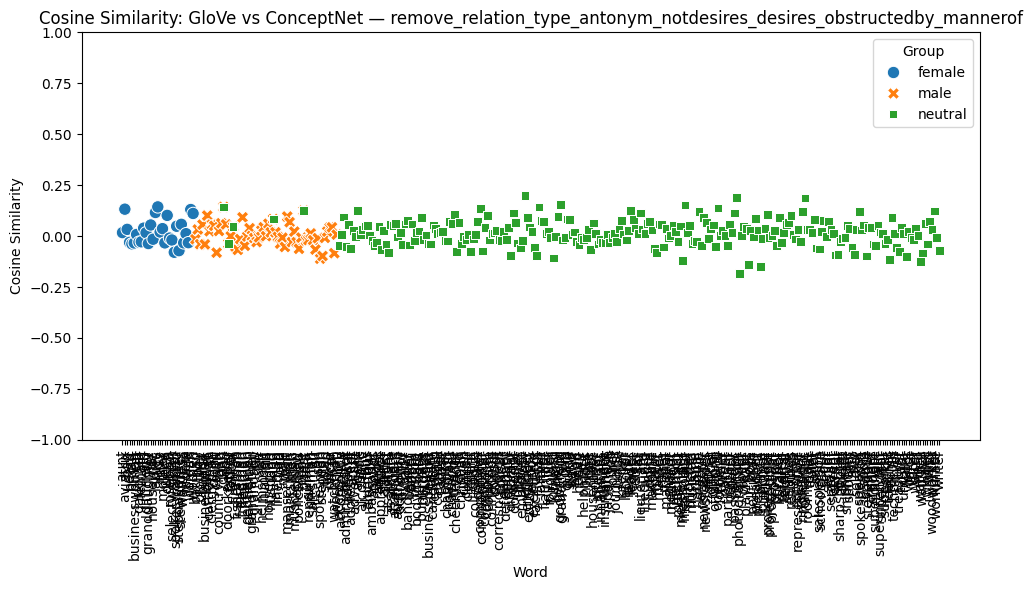

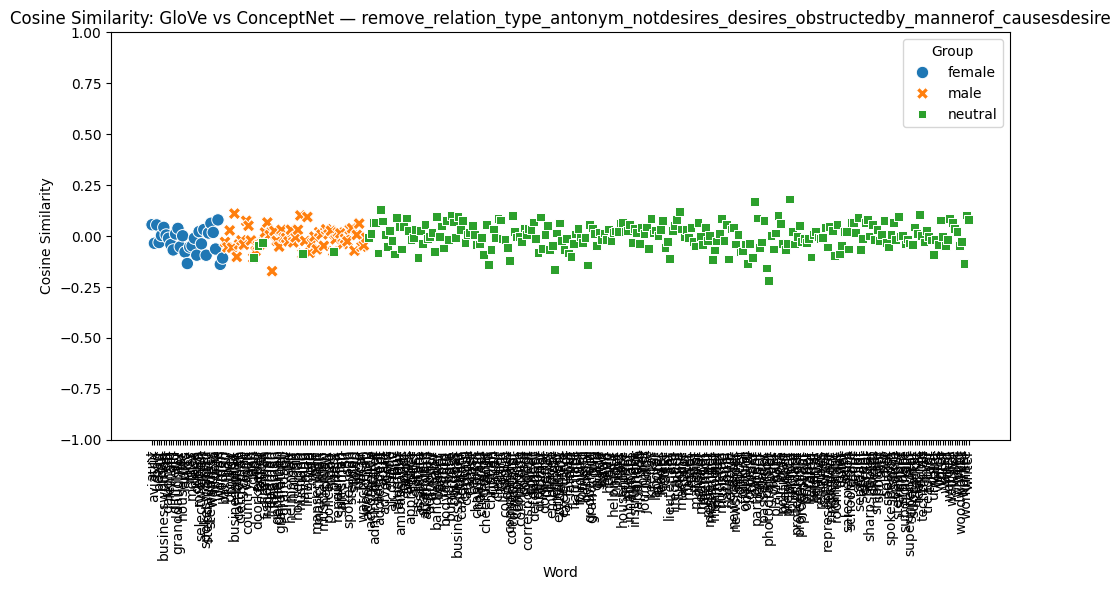

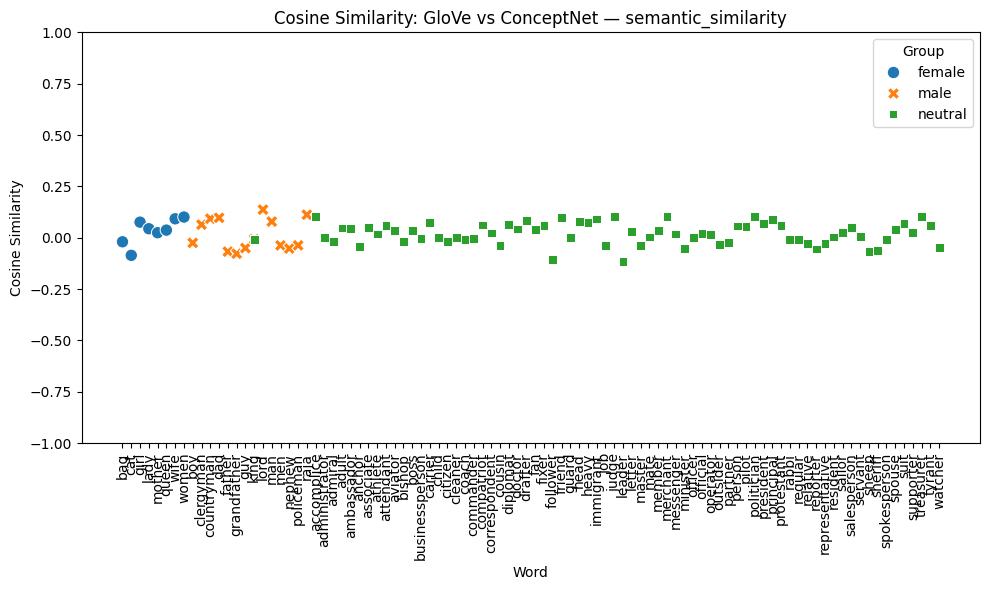

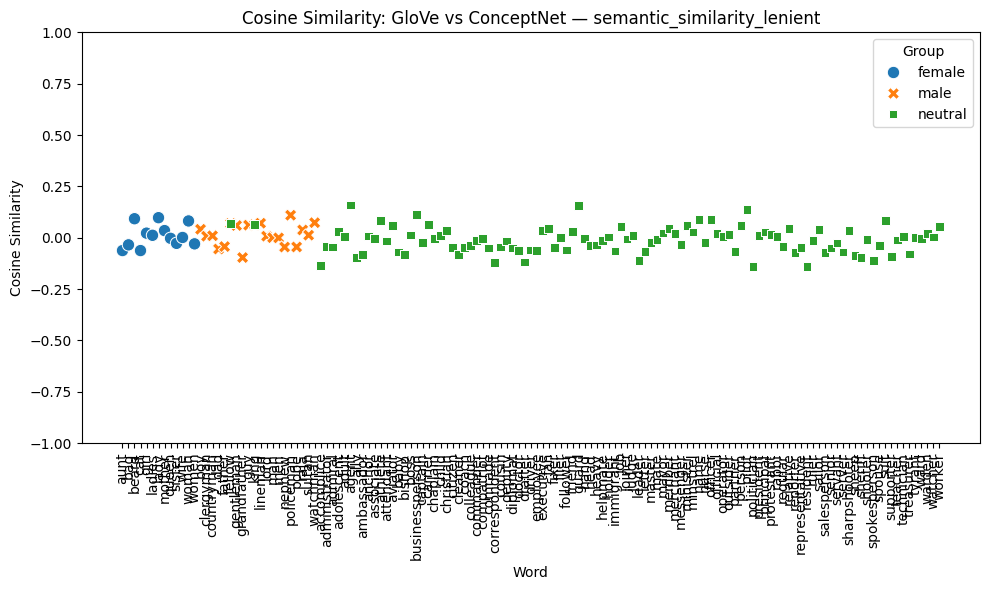

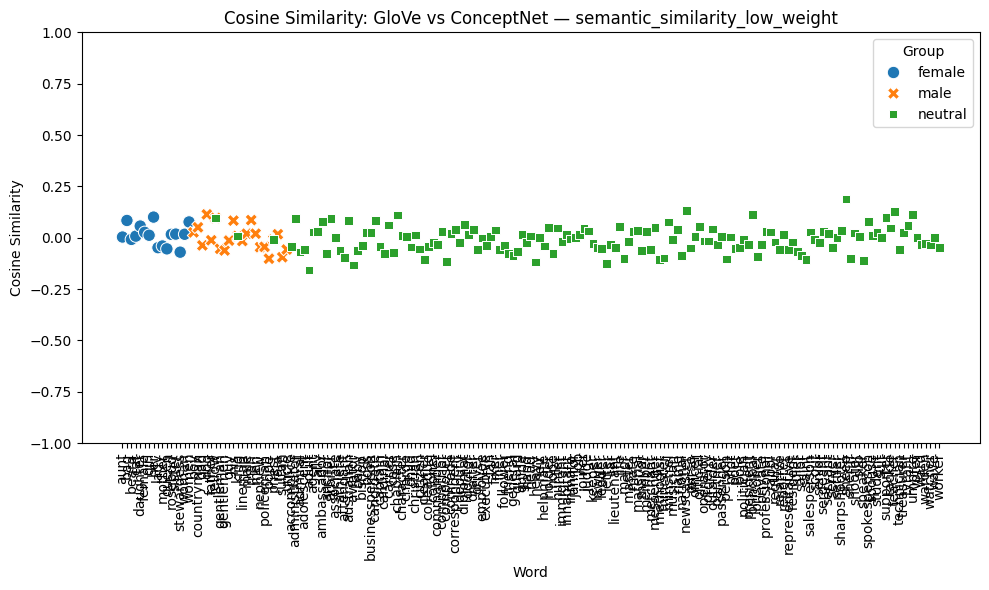

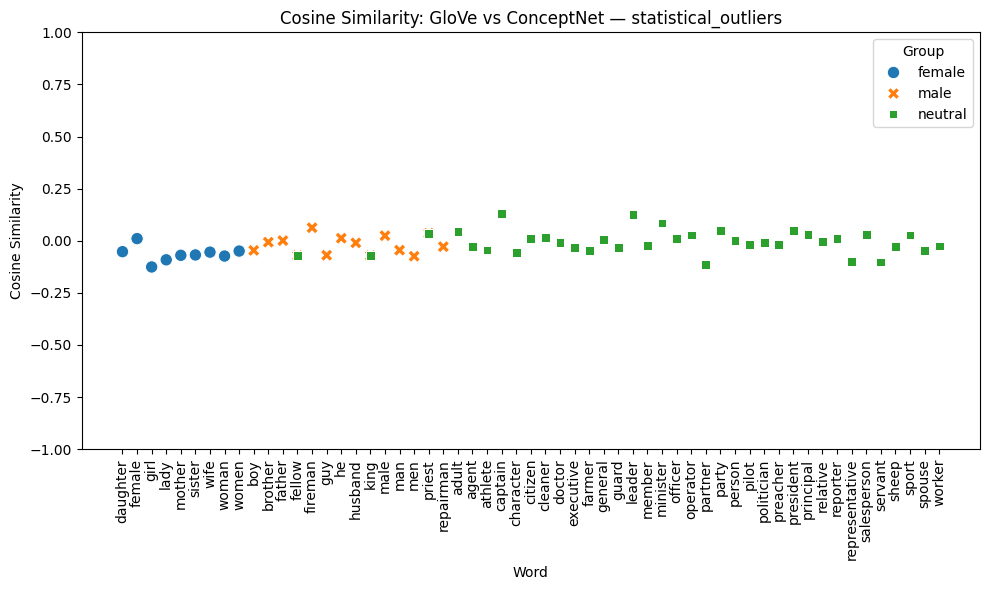

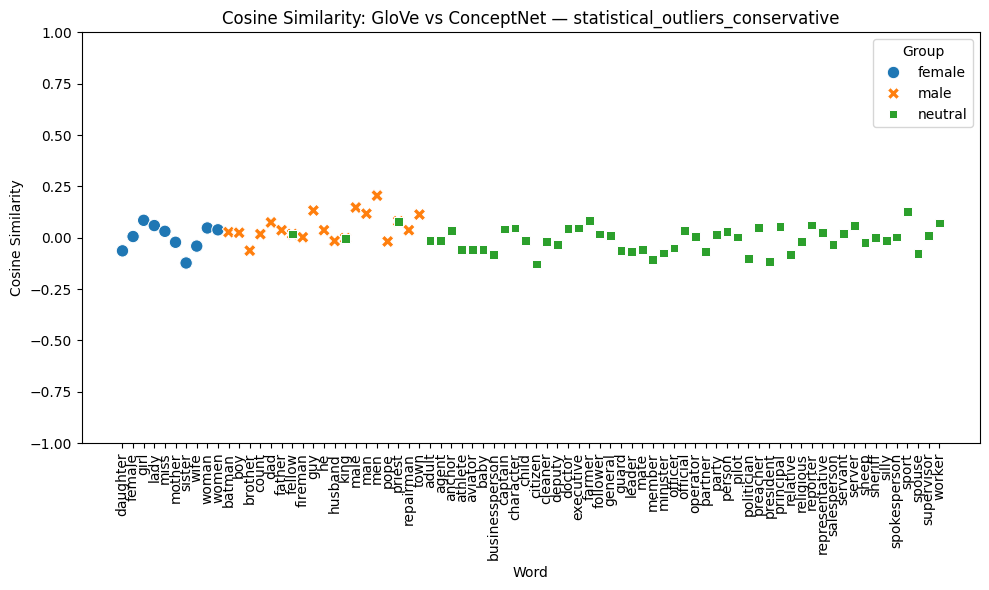

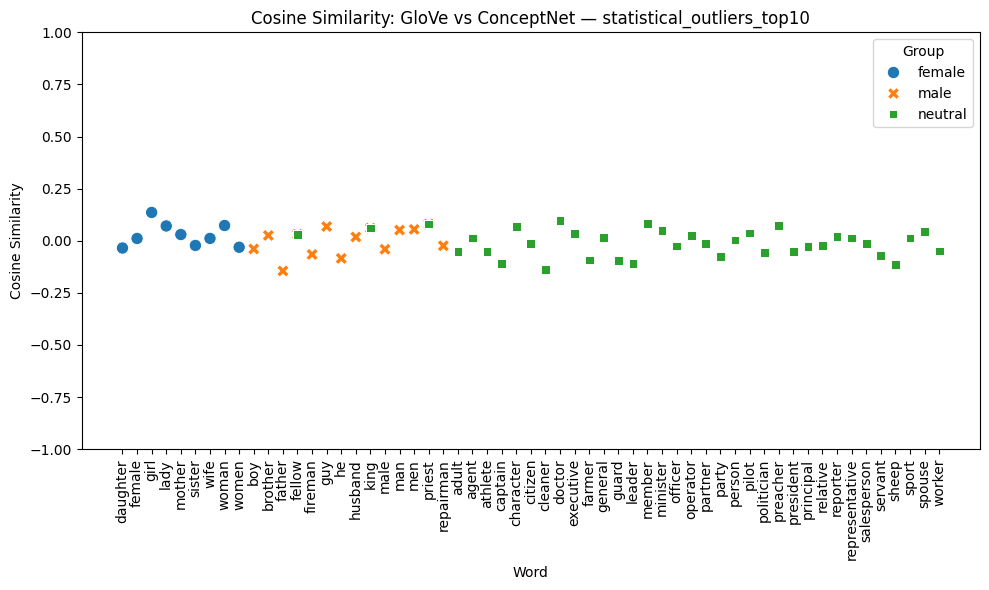

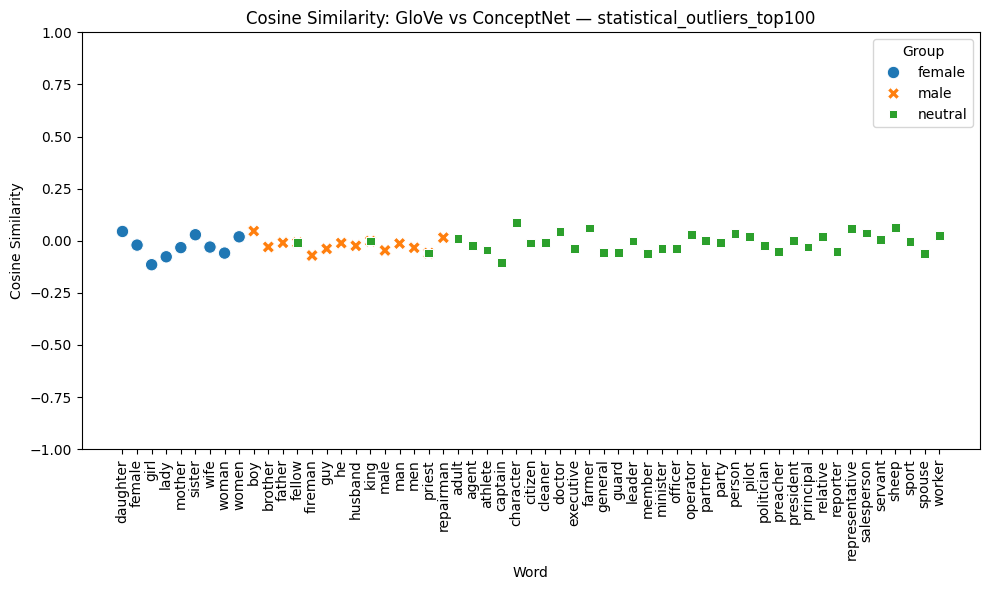

In [146]:
### Some plots to visualise 
import matplotlib.pyplot as plt
import seaborn as sns

# --- Settings ---
BASE_DIR = "data/conceptnet_api/eval/cosine_similarity"
groups = ["female", "male", "neutral"]  # word group
filters = os.listdir(BASE_DIR)          # auto-detect all filter folders

# --- Collect Data ---
data = []

for filter_name in filters:
    for group in groups:
        file_path = os.path.join(BASE_DIR, filter_name, f"{group}_glove_vs_conceptnet.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            for _, row in df.iterrows():
                data.append({
                    "word": row["word"],
                    "similarity": row["cosine_similarity"],
                    "group": group,
                    "filter": filter_name
                })

# --- Convert to DataFrame ---
all_sim_df = pd.DataFrame(data)

# --- Plot (One Plot Per Filter) ---
for filter_name in all_sim_df["filter"].unique():
    subset = all_sim_df[all_sim_df["filter"] == filter_name]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=subset, x="word", y="similarity", hue="group", style="group", s=80)
    plt.xticks(rotation=90)
    plt.title(f"Cosine Similarity: GloVe vs ConceptNet — {filter_name}")
    plt.xlabel("Word")
    plt.ylabel("Cosine Similarity")
    plt.ylim(-1, 1)
    plt.legend(title="Group")
    plt.tight_layout()
    plt.savefig(f"data/conceptnet_api/eval/cosine_similarity_plot_{filter_name}.png")
    plt.show()


In [129]:
### Bernard's hdf files for evaluation 
retrofitted_baseline_albert = "data/conceptnet_api/hdf/retrofitted-baseline-albert-128.hdf"
retrofitted_custom_albert = "data/conceptnet_api/hdf/retrofitted-custom-albert-128.hdf"
retrofitted_baseline_mobilebert = "data/conceptnet_api/hdf/retrofitted-baseline-mobilebert-128.hdf"
retrofitted_custom_mobilebert =  "data/conceptnet_api/hdf/retrofitted-custom-mobilebert-128.hdf"

retrofitted_baseline_albert_df = pd.read_hdf(retrofitted_baseline_albert)
retrofitted_custom_albert_df = pd.read_hdf(retrofitted_custom_albert)
retrofitted_baseline_mobilebert_df = pd.read_hdf(retrofitted_baseline_mobilebert)
retrofitted_custom_mobilebert_df = pd.read_hdf(retrofitted_custom_mobilebert)

EVAL_OUTPUT = "data/conceptnet_api/eval"
os.makedirs(EVAL_OUTPUT, exist_ok=True)
summary_path = os.path.join(EVAL_OUTPUT, "bert_eval_summary.txt")

embedding_variants = {
    "baseline_albert": retrofitted_baseline_albert_df,
    "custom_albert": retrofitted_custom_albert_df,
    "baseline_mobilebert": retrofitted_baseline_mobilebert_df,
    "custom_mobilebert": retrofitted_custom_mobilebert_df
}

with open(summary_path, "w") as f:
    for name, ppmi_df in embedding_variants.items():
        print(f"Evaluating: {name}")
        f.write(f"===== Evaluation for: {name} =====\n")

        # Compute gender direction
        try:
            gender_dir = compute_gender_direction(gender_pairs, gender_pairs2, ppmi_df)
        except ValueError as e:
            f.write(f"⚠️ Skipping {name}: {str(e)}\n\n")
            continue

        # Compute SAME biases
        bias_same_neutral = delta_same(neutral_words_target, attribute_set_a, attribute_set_b, ppmi_df)
        bias_same_male = delta_same(male_words_target, attribute_set_a, attribute_set_b, ppmi_df)
        bias_same_female = delta_same(female_words_target, attribute_set_a, attribute_set_b, ppmi_df)

        # Compute direct bias for "human"
        bias_direct_computer = direct_bias("/c/en/computer", gender_dir, ppmi_df)

        # Log to file
        f.write(f"SAME Bias (Neutral): {bias_same_neutral:.4f}\n")
        f.write(f"SAME Bias (Male):    {bias_same_male:.4f}\n")
        f.write(f"SAME Bias (Female):  {bias_same_female:.4f}\n")
        f.write(f"Direct Bias ('/c/en/computer'): {bias_direct_computer:.4f}\n")
        f.write("--------------------------------------------------\n\n")

Evaluating: baseline_albert
Evaluating: custom_albert
Evaluating: baseline_mobilebert
Evaluating: custom_mobilebert
